# `kl_divergence_profile` function walkthrough
This function calculates the Kullback-Leiber (KL) divergence of different areas and the total population, in order to create a divergence profile across the whole area. This provides a multi-scalar measurement of the segregation, understanding how each area of a population interacts with those areas in close and distant proximity to it.

For theoretical background to this methodology, please see the [Olteanu et al. (2019)](https://doi.org/10.1073/pnas.1900192116) article that inspired the creation of this function within PySAL's library.

Many thanks to the work of [Cécile de Bézenac](https://github.com/ceciledebezenac/segregation_index), who's primary iteration of a wrapped code to compute this metric was incredibly helpful in directing this function's interpretation.

## Contents
1. **[The function](#The-function)** - the full function from the PySAL library


2. **[Cincinnati example dataset](#Cincinnati-(cincin)-example-dataset)** - an overview of the example dataset used in the walkthrough, and creating the different forms of input acceptable for the data


2. **[Making the function work](#Making-the-function-work)** - providing the functions with the correct inputs to ensure that this will run successfully


3. **[Using the outputs](#Using-the-outputs)** - how the outputs can be deconstructed to create useful visualisations


4. **[How the function works](#How-the-function-works)** - taking a step-by-step work through of the inner workings of the function to understand exactly what it is doing

## The function

In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.special import rel_entr as relative_entropy


def kl_divergence_profile(populations, coordinates = None, metric = 'euclidean'):
    """
    A segregation metric, using Kullback-Leiber (KL) divergence to quantify the
    difference in the population characteristics between (1) an area and (2) the total population.

    This function utilises the methodology proposed in
    Olteanu et al. (2019): 'Segregation through the multiscalar lens'. Which can be
    found here: https://doi.org/10.1073/pnas.1900192116

    Arguments
    ----------
    populations : GeoPandas GeoDataFrame object
                  Pandas DataFrame object
                  NumPy Array object
                  Population information of raw group numbers (not percentages) to be
                  included in the analysis.
    coordinates : GeoPandas GeoSeries object
                  NumPy Array object
                  Spatial information relating to the areas to be included in the analysis.
    metric : Acceptable inputs to `scipy.spatial.distance.pdist` - including:
             ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’,
             ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’,
             ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’,
             ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
             Distance metric for calculating pairwise distances,
             using `scipy.spatial.distance.pdist` - 'euclidean' by default.

    Returns
    ----------
    observation : an identifier of the area that forms the centre of the aggregation
                  of population, from which the divergence is calculated.
    distance : how far the most recently aggregated area is from the 'observation'
               area, starting at zero for each observation to represent that only the
               'observation' area being aggregated.
    divergence : the KL divergence measure, between the aggregated population and the
                 total population, will converge to zero for the final row of each
                 observation to represent that the total population is covered.
    population_covered : the population count within the aggregated population.
    Returns a concatenated object of Pandas dataframes. Each dataframe contains a
    set of divergence levels between an area and the total population. These areas
    become consecutively larger, starting from a single location and aggregating
    outward from this location, until the area represents the total population.
    Thus, together the divergence levels within a dataframe represent a profile
    of divergence from an area. The concatenated object is the collection of these
    divergence profiles for every areas within the total population.

    Example
    ----------
    from libpysal.examples import get_path
    from libpysal.examples import load_example
    cincin = load_example('Cincinnati')
    cincin.get_file_list()
    cincin_df = gpd.read_file(cincin.get_path('cincinnati.shp'))
    cincin_ethnicity = cincin_df[["WHITE", "BLACK", "AMINDIAN", "ASIAN", "HAWAIIAN", "OTHER_RACE", "geometry"]]
    cincin_ethnicity.head()
    kl_divergence_profile(cincin_ethnicity)
    """
    # Store the observation index to return with the results
    if hasattr(populations, 'index'):
        indices = populations.index
    else:
        indices = np.arange(len(populations))

    # Check for geometry present in populations argument
    if hasattr(populations, 'geometry'):
        if coordinates is None:
            coordinates = populations.geometry
        populations = populations.drop(populations.geometry.name, axis = 1).values
    populations = np.asarray(populations)

    #  Creating consistent coordinates - GeoSeries input
    if hasattr(coordinates,'geometry'):
        centroids = coordinates.geometry.centroid
        coordinates = np.column_stack((centroids.x, centroids.y))
    #  Creating consistent coordinates - Array input
    else:
        assert len(coordinates) == len(populations), "Length of coordinates input needs to be of the same length as populations input"

    # Creating distance matrix using defined metric (default euclidean distance)
    dist_matrix = squareform(pdist(coordinates, metric = metric))

    # Preparing list for results
    results = []

    # Loop to calculate KL divergence profile
    for (i, distances) in enumerate(dist_matrix):

        # Creating the q and r objects
        sorted_indices = np.argsort(distances)
        cumul_pop_by_group = np.cumsum(populations[sorted_indices], axis = 0)
        obs_cumul_pop = np.sum(cumul_pop_by_group, axis = 1)[:, np.newaxis]
        q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop
        total_pop_by_group = np.sum(populations, axis = 0, keepdims = True)
        total_pop = np.sum(populations)
        r_total_proportions = total_pop_by_group / total_pop

        # Input q and r objects into relative entropy (KL divergence) function
        kl_divergence = relative_entropy(q_cumul_proportions,
                                         r_total_proportions).sum(axis = 1)

        # Creating an output dataframe
        output = pd.DataFrame().from_dict(dict(
            observation = indices[i],
            distance = distances[sorted_indices],
            divergence = kl_divergence,
            population_covered = obs_cumul_pop.sum(axis=1)
        ))

        # Append (bring together) all outputs into results list
        results.append(output)

    return(pd.concat(results))




## Cincinnati (cincin) example dataset

For this example, we will be using an example dataset that is available via the [`examples`](https://pysal.org/notebooks/lib/libpysal/Example_Datasets.html) package of **`libpysal`** - it is a remote dataset, originating from the GeoDa program, an output of the [Center for Spatial Data Science at the Unversity of Chicago](https://spatial.uchicago.edu).

This dataset is entitled '[**2008 Cincinnati Crime + Socio-Demographics**](https://geodacenter.github.io/data-and-lab/walnut_hills/)', and contains "*Crime and socio-demographic data for the Clifton, Walnut Hills, Evanston, and Avondale neighborhoods in Cincinnati, OH for the last 6 months of 2008*".

Throughout this workbook, we will only be inputting the socio-demographic information it possesses. The total population of Cincinnati can be broken down within the data by six different ethnic groups: *AMINDIAN* (American-Indian), *ASIAN*, *BLACK*, *HAWAIIAN*, *WHITE*, and *OTHER_RACE*.

This data will be referred to it as ***cincin*** throughout.

You can read in this example dataset, and then repeat all the code in this notebook, by doing the following:

In [2]:
import geopandas as gpd
from libpysal.examples import get_path
from libpysal.examples import load_example

cincin = load_example('Cincinnati')
cincin = gpd.read_file(cincin.get_path('cincinnati.shp'))
cincin = cincin.set_index('ID')

Example not available: Cincinnati
Example not downloaded: Chicago parcels
Example not downloaded: Chile Migration
Example not downloaded: Spirals


Having read in this shapefile - as ***cincin*** - the data required for this analysis can be collected using either a *geodataframe* (gdf) or a combination of a *dataframe* (df) and *geoseries* data.

In [3]:
cincin_gdf = cincin[["WHITE", "BLACK", "AMINDIAN", "ASIAN", "HAWAIIAN", "OTHER_RACE", "geometry"]]
cincin_gdf

,WHITE,BLACK,AMINDIAN,ASIAN,HAWAIIAN,OTHER_RACE,geometry
ID,,,,,,,
726907.0,433.0,32.0,0.0,5.0,0.0,2.0,"POLYGON ((1407302.966 415693.734, 1407473.141 ..."
695744.0,16.0,66.0,0.0,0.0,0.0,0.0,"POLYGON ((1398841.243 416718.444, 1399605.382 ..."
695762.0,15.0,12.0,0.0,1.0,0.0,1.0,"POLYGON ((1398733.468 416975.853, 1398794.240 ..."
695780.0,12.0,103.0,0.0,0.0,0.0,2.0,"POLYGON ((1399564.078 416046.633, 1399605.382 ..."
695798.0,52.0,39.0,0.0,1.0,0.0,0.0,"POLYGON ((1398841.243 416718.444, 1398733.468 ..."
...,...,...,...,...,...,...,...
703629.0,5.0,102.0,0.0,0.0,1.0,2.0,"POLYGON ((1401900.256 422880.130, 1401964.217 ..."
703648.0,0.0,85.0,0.0,1.0,0.0,0.0,"POLYGON ((1402856.266 422494.690, 1403591.085 ..."
703666.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((1402861.897 422749.576, 1402925.846 ..."


In [4]:
cincin_df = cincin[["WHITE", "BLACK", "AMINDIAN", "ASIAN", "HAWAIIAN", "OTHER_RACE"]]
cincin_df

,WHITE,BLACK,AMINDIAN,ASIAN,HAWAIIAN,OTHER_RACE
ID,,,,,,
726907.0,433.0,32.0,0.0,5.0,0.0,2.0
695744.0,16.0,66.0,0.0,0.0,0.0,0.0
695762.0,15.0,12.0,0.0,1.0,0.0,1.0
695780.0,12.0,103.0,0.0,0.0,0.0,2.0
695798.0,52.0,39.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
703629.0,5.0,102.0,0.0,0.0,1.0,2.0
703648.0,0.0,85.0,0.0,1.0,0.0,0.0
703666.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
cincin_geoseries = cincin[['geometry']]
cincin_geoseries

,geometry
ID,
726907.0,"POLYGON ((1407302.966 415693.734, 1407473.141 ..."
695744.0,"POLYGON ((1398841.243 416718.444, 1399605.382 ..."
695762.0,"POLYGON ((1398733.468 416975.853, 1398794.240 ..."
695780.0,"POLYGON ((1399564.078 416046.633, 1399605.382 ..."
695798.0,"POLYGON ((1398841.243 416718.444, 1398733.468 ..."
...,...
703629.0,"POLYGON ((1401900.256 422880.130, 1401964.217 ..."
703648.0,"POLYGON ((1402856.266 422494.690, 1403591.085 ..."
703666.0,"POLYGON ((1402861.897 422749.576, 1402925.846 ..."


## Making the function work

The function is designed for you to input data in one of three ways - that are outlined below:

### 1. `kl_divergence_profile(populations = geodataframe)`
A geodataframe can be used as the sole input to the function. However, for this to work as desired, it **must only contain** columns of the raw data for group counts (for ***cincin*** this is the ethnic groups) along with the geometry column. This geometry must be in polygon form or point form (of the centroid of each area.

In [6]:
kl_divergence_profile(cincin_gdf)

<ipython-input-1-8d5700952c7a>:100: RuntimeWarning: invalid value encountered in true_divide
  q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop


,observation,distance,divergence,population_covered
0,726907.0,0.000000,8.964293e-01,472.0
1,726907.0,674.319177,3.970494e-01,654.0
2,726907.0,755.315782,3.966244e-01,728.0
3,726907.0,830.744890,3.082997e-01,872.0
4,726907.0,1067.478163,3.110239e-01,981.0
...,...,...,...,...
452,703708.0,13063.729732,1.881053e-06,37805.0
453,703708.0,13099.457827,1.377660e-06,37874.0
454,703708.0,13163.435867,1.492472e-06,37919.0
455,703708.0,13170.741000,1.595123e-07,37963.0


Here we have our first look at the output for the KL divergence profile function. This is four columns, containing:
- **observation** - an identifier of the area that forms the centre of the aggregation of population, from which the divergence is calculated.
- **distance** - how far the most recently aggregated area is from the 'observation' area, starting at zero for each observation to represent that the 'observation' area is the only one being aggregated.
- **divergence** - the KL divergence measure, between the aggregated population and the total population, will converge to zero for the final row of each observation to represent that the total population is covered.
- **nearby_population** - the population count within the aggregated population.

### 2. `kl_divergence_profile(populations = geodataframe[groups], coordinates = geodataframe.geometry.centroid)`
If a geodataframe contains other columns, that are not desired to be used in the analysis - such as the original ***cincin*** dataset - this can be included as the input by subsetting only the columns that are desired.

In order for this to work, the coordinates input must then be used to specify the spatial location of each observation. While point or polygon geoseries format can be passed, output from the geopandas `centroid` command will pass smoothly.

In [7]:
kl_divergence_profile(populations = cincin_gdf[["WHITE", "BLACK", "AMINDIAN", "ASIAN", "HAWAIIAN", "OTHER_RACE"]],
                     coordinates = cincin_gdf[["geometry"]].centroid)

<ipython-input-1-8d5700952c7a>:100: RuntimeWarning: invalid value encountered in true_divide
  q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop


,observation,distance,divergence,population_covered
0,726907.0,0.000000,8.964293e-01,472.0
1,726907.0,674.319177,3.970494e-01,654.0
2,726907.0,755.315782,3.966244e-01,728.0
3,726907.0,830.744890,3.082997e-01,872.0
4,726907.0,1067.478163,3.110239e-01,981.0
...,...,...,...,...
452,703708.0,13063.729732,1.881053e-06,37805.0
453,703708.0,13099.457827,1.377660e-06,37874.0
454,703708.0,13163.435867,1.492472e-06,37919.0
455,703708.0,13170.741000,1.595123e-07,37963.0


The function will also run if the geometry polygon information is inputted into the *coordinates* argument - without being converted into centroid points. If this is done, the `centroid` command is ran as part of the function to distinguish a point against which distance is calculated.

i.e: an alternative input is

`kl_divergence_profile(populations = cincin_gdf[["WHITE", "BLACK", "AMINDIAN", "ASIAN", "HAWAIIAN", "OTHER_RACE"]], coordinates = cincin_gdf[["geometry"]])`

### 3. `kl_divergence_profile(populations = dataframe, coordinates = geoseries)`
If the population data is contained in a separate object to the spatial, geoseries information - as long as the indexing (order) of both datasets is consistent - they can be inputted separately into the function.

In [8]:
kl_divergence_profile(populations = cincin_df, coordinates = cincin_geoseries)

<ipython-input-1-8d5700952c7a>:100: RuntimeWarning: invalid value encountered in true_divide
  q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop


,observation,distance,divergence,population_covered
0,726907.0,0.000000,8.964293e-01,472.0
1,726907.0,674.319177,3.970494e-01,654.0
2,726907.0,755.315782,3.966244e-01,728.0
3,726907.0,830.744890,3.082997e-01,872.0
4,726907.0,1067.478163,3.110239e-01,981.0
...,...,...,...,...
452,703708.0,13063.729732,1.881053e-06,37805.0
453,703708.0,13099.457827,1.377660e-06,37874.0
454,703708.0,13163.435867,1.492472e-06,37919.0
455,703708.0,13170.741000,1.595123e-07,37963.0


For those of you on-the-ball, you may notice that this input is rather similar to that suggested as an alternative input to step 2 - the data inputted is exactly the same in this case.

However, due to the available format of your own data, or purely due to personal preference, you may prefer to input two separate objects to the *populations* and *coordinates* arguments.

## Using the outputs

In [9]:
cincin_kl_divergence = kl_divergence_profile(cincin_gdf)

<ipython-input-1-8d5700952c7a>:100: RuntimeWarning: invalid value encountered in true_divide
  q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop


<AxesSubplot:xlabel='distance'>

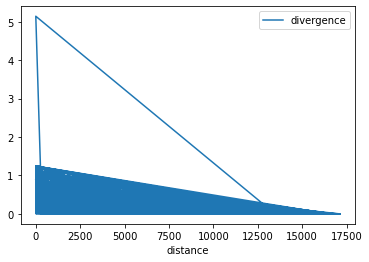

In [10]:
cincin_kl_divergence.plot("distance", "divergence")

In [11]:
cincin_kl_divergence = cincin_kl_divergence.groupby('observation').first().reset_index()

In [12]:
cincin_kl_divergence = cincin_kl_divergence.merge(cincin_geoseries, left_on = 'observation', right_on = 'ID')
cincin_kl_divergence

,observation,distance,divergence,population_covered,geometry
0,654795.0,0.0,0.142210,69.0,"POLYGON ((1398269.926 411448.786, 1398333.955 ..."
1,654816.0,0.0,0.060205,49.0,"POLYGON ((1397564.804 411646.644, 1397600.475 ..."
2,654853.0,0.0,0.210239,0.0,"POLYGON ((1397634.522 412227.972, 1397580.224 ..."
3,654869.0,0.0,0.189339,44.0,"POLYGON ((1397788.495 411495.938, 1397826.597 ..."
4,654889.0,0.0,0.210239,142.0,"POLYGON ((1397634.522 412227.972, 1397695.312 ..."
...,...,...,...,...,...
452,739686.0,0.0,1.244836,45.0,"POLYGON ((1410127.237 417672.072, 1410268.460 ..."
453,741823.0,0.0,0.934698,29.0,"POLYGON ((1410140.124 416441.192, 1410495.720 ..."
454,741843.0,0.0,0.945546,256.0,"POLYGON ((1408692.225 416938.374, 1408734.116 ..."
455,741889.0,0.0,1.244836,10.0,"POLYGON ((1411000.065 417361.617, 1411163.889 ..."


<AxesSubplot:>

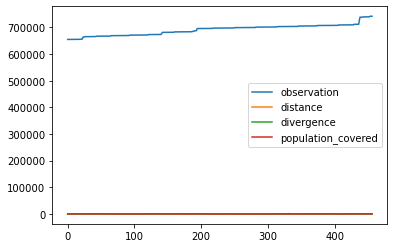

In [13]:
from matplotlib.pyplot import plot

cincin_kl_divergence.plot()

## How the function works
Here the code will be broken down into its constituent parts, in order to explain how it works to create the complete `kl_divergence_profile` function.

### The bigger picture

The methodology suggested by [Olteanu et al. (2019)](https://doi.org/10.1073/pnas.1900192116) inventively calculates consecutive divergence levels in relation to a chosen area within a city.

To do this, the KL divergence calculations consectively aggregate more and more population. This aggregation starts by including solely the population of this chosen area, then including populations of the closest neighbour to the chosen area, followed by the next closest neighbour, and so on until the population of the whole city is analysed.

The result is a profile of divergence levels that represents an aggregation of population gradually from this chosen area, showing how the dynamics of a population change as you consider areas covering a larger and larger distance from this chosen area.

Once this has been undertaken for a single chosen area, it can be repeated for every other area within the city.

When analysed on this scale, this gives a more nuanced picture of which areas of a city closest represent the total population of the city, and vice versa which areas are most different to the total population of the city; along with their spatial relationships.

### Managing inputs
First, as there are different forms of input possible, they need to be managed into a consistent form that will eventually be used to calculate the KL divergence.

As a reminder, this function currently has three arguments that you can use to tailor it to your own data:

```python
def kl_divergence_profile(populations, coordinates = None, metric = 'euclidean'):
```

Where:
- ***populations*** - is data regarding each group within the population information to be included in the analysis (in raw numbers, not percentages)
- ***coordinates*** - is the spatial information, relating to the population information  inputted within the *populations* argument
- ***metric*** - the style of distance metric to be used in calculating the distances between areas, such that they can be ordered

#### Storing indices

If the *populations* input contains an [index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html), then it is stored, such that the results can be related to the inputted data more easily. If not, an array is created to take this place.

```python
    # Store the observation index to return with the results
    if hasattr(populations, 'index'):
        indices = populations.index
    else:
        indices = np.arange(len(populations))
```

#### Creating *coordinates* from a geodataframe input to *populations*

If the *populations* input has a geometry attribute, and there is no *coordinates* input, then the geometry of the *populations* input is passed as the *coordinates* input. The *populations* input is then stripped of its geometry attribute, and converted into an array.

```python
    # Check for geometry present in populations argument
    if hasattr(populations, 'geometry'):
        if coordinates is None:
            coordinates = populations.geometry
        populations = populations.drop(populations.geometry.name, axis = 1).values
    populations = np.asarray(populations)
```

#### Ensuring *coordinates* is centroid's coordinates

Regardless whether the *coordinates* input has a point or polygon geometry attribute, the `centroid` of each observation is calculated and re-stored as *coordinates* in a two column array, representing the *x* and *y* values.

A test is inputted into this using a *else* clause, whereby if the *coordinates* and *populations* inputs are not of equal length, then the user is warned of this.

```python
    #  Creating consistent coordinates - GeoSeries input
    if hasattr(coordinates,'geometry'):
        centroids = coordinates.geometry.centroid
        coordinates = np.column_stack((centroids.x, centroids.y))
    #  Creating consistent coordinates - Array input
    else:
        assert len(coordinates) == len(populations), "Length of coordinates input needs to be of the same length as populations input"
```

### Creating a distance matrix
Having managed the inputs, we have to think about how we want the KL divergence levels to be calculated.

To create this a divergence profile over space, we first need to be able to sort the inputted data in terms of their proximity to the chosen area of the analysis.

A distance matrix is therefore created, to store the distances between each observation and every other observation. This uses the [`pdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) function from *scipy.spatial.distance* to compute this, using the optional *metric* argument from the input of the function.

This calculates the Euclidean (also known as Pythagorean) distance between all the points by default, but could be altered as desired by the user using the *metric* input.

``` python
    # Creating distance matrix using defined metric (default euclidean distance)
    dist_matrix = squareform(pdist(coordinates, metric = metric))
```

### Creating a list for the results
This is purely a piece of admin to open a list, such that the results can be filled into this (currently empty) list later in the function.

``` python
    # Preparing list for results
    results = []
```

### Undertaking the loop

#### Part A - Sorting the population information by the distance matrix

In order to undertake all of the statistical work with regards to the *populations* input, the data must first be ordered by the distance matrix, which has been created above.

For instance - when the *metric* is set to Euclidean - for an example observation '*A*', sorting by the distance matrix will return the *populations* information ordered from closest observation to the furthest observation, all with respect to observation *A*.

``` python
    # Loop to calculate KL divergence
    for (i, distances) in enumerate(dist_matrix):

        # Creating the q and r objects
        sorted_indices = np.argsort(distances)
```

The `sorted_indices` can then be used as a method of ordering the *populations* object, which we will see in the next part of the loop.

#### Part B - Preparing the inputs to calculate the KL divergence
With the end goal of this function being is to calculate the KL divergence - specific inputs for this calculation must be created.

In the article, Olteanu et al. state that
> $\text{"}$ The KL divergence between two multinomial distributions (*$\space q_1, \space ... \space , q_k$* ) , (*$\space r_1, \space ... \space , r_k$* ) is defined as:
> $$ d_{KL}(q \space|\space r) = \sum_{i=1}^{k} q_i \space ln \space{{q_i} \over {r_i}} \space \space \text{"}  $$
> [Olteanu et al. (pg. 12250, 2019)](https://doi.org/10.1073/pnas.1900192116)

When applied in practice, we create statistics from the distributions such that

$$ ln \space {{q_i} \over {r_i}} \space = \space ln \space {{{{cumulative \space proportions}\space_i}} \over {{total \space proportions}\space_i}} $$ 

The *culmulative proportions* and *total proportions* objects are the inputs that will be used to calculate the KL divergence for each area.

- **cumulative proportions** - culmulatively aggregating with respect to the chosen area, the proportion (percentage) that each group represents
- **total proportions** - the proportions (percentages) each group represents in the total population, placed into an ordered list

Therefore, to calculate *cumulative proportions* (`q_cumul_proportions`), the objects representing the culmulative group populations (`cumul_pop_by_group`) and culmulative total populations (`obs_cumul_pop`) are created.

``` python
        cumul_pop_by_group = np.cumsum(populations[sorted_indices], axis = 0)
        obs_cumul_pop = np.sum(cumul_pop_by_group, axis = 1)[:, np.newaxis]
        q_cumul_proportions = cumul_pop_by_group / obs_cumul_pop
```

To calculate *total proportions* (`r_total_proportions`), the objects representing the total group populations (`total_pop_by_group`) and total populations (`total_pop`) are created

``` python
        total_pop_by_group = np.sum(populations, axis = 0, keepdims = True)
        total_pop = np.sum(populations)
        r_total_proportions = total_pop_by_group / total_pop
```

#### Part C - Calculating the KL divergence
To calculate the KL divergence profile, the two objects created to form the *q* and *r* elements of the formula are inputted into the [`scipy.special.rel_entr`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.rel_entr.html) function.

While a [`scipy.special.kl_div`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.special.kl_div.html#scipy.special.kl_div) also exists - and might be thought to be the obvious choice - the relative entropy function contains beneficial functionality for this use-case as a result of its handling of $ln(0)$, where it bends the rule of mathematics to return $0$ instead of $- \infty$. For measuring population statistics, this makes a lot more logical sense.

``` python
        # Input q and r objects into relative entropy (KL divergence) function
        kl_divergence = relative_entropy(q_cumul_proportions,
                                         r_total_proportions).sum(axis = 1)
```

####  Part D - Placing the outputs into a dataframe
Now we have undertaken all the calculations, a dataframe for the outputs can be constructed, returning the four outputs we have [already discussed](#1.-kl_divergence_profile(populations-=-geodataframe)).

``` python
        # Creating an output dataframe
        output = pd.DataFrame().from_dict(dict(
            observation = indices[i],
            distance = distances[sorted_indices],
            divergence = kl_divergence,
            population_covered = obs_cumul_pop.sum(axis=1)
        ))
```

### Bringing all the dataframes together
Finally, the *output* dataframes relating to each observation are brought together and concatenated (stacked) using the [`pandas.concat`](https://pandas.pydata.org/docs/reference/api/pandas.concat.html) function to return our full output. Designed to be deconstructed, broken down and used for visualisations and further analysis.

``` python
        # Append (bring together) all outputs into results list
        results.append(output)

    return(pd.concat(results))
```